In [1]:
import json
import pickle
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.spatial.distance import cdist,euclidean
from tqdm import tqdm

plt.style.use('ggplot')
#plt.rcParams["figure.figsize"] = (20,3)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch_geometric
import torch_geometric.utils
from torch_geometric.utils import from_networkx

In [48]:
data_path = './scidocs/data/'
paper_cite_file = data_path + 'paper_metadata_view_cite_read.json'
paper_cls_file = data_path + 'paper_metadata_mag_mesh.json'
paper_rec_file = data_path + 'paper_metadata_recomm.json'
user_activity_and_citations_embeddings_path = data_path + 'specter-embeddings/user-citation.jsonl'

## Look at the data

In [3]:
papers_data = {}
with open(paper_cite_file, 'r') as f:
    papers_data = json.load(f)

In [4]:
list(list(papers_data.values())[0].keys())

['abstract', 'authors', 'cited_by', 'paper_id', 'references', 'title', 'year']

In [5]:
papers_data = {}
with open(paper_rec_file, 'r') as f:
    papers_data = json.load(f)

In [6]:
list(list(papers_data.values())[0].keys())

['abstract', 'authors', 'cited_by', 'paper_id', 'references', 'title', 'year']

In [7]:
papers_df = pd.DataFrame(papers_data).T

In [8]:
#extra column
all(papers_df.index == papers_df.paper_id)

True

In [9]:
papers_df.head(5)

,abstract,authors,cited_by,paper_id,references,title,year
0002c0f45b3ef0f1491f91cbfefe9543e9af6163,In this paper we introduce an hp certified red...,"[3122778, 39921175, 1905947, 2848614]","[16728d6f0a225bb8a71ebe4d0acd2512ca775327, 48d...",0002c0f45b3ef0f1491f91cbfefe9543e9af6163,"[07e1f620f68c0be579fb05bf6d231fa06b0db7c3, 7f2...",An hp Certified Reduced Basis Method for Param...,2011
0004d38aa501306e2719e4d0413dcb5c788676b1,We test whether momentum strategies remain pro...,[],"[67d88e58812562f0270b7077408776157a542fbf, 946...",0004d38aa501306e2719e4d0413dcb5c788676b1,"[18cb63580217983f2fd4b54141b2f83b96819dd3, 360...",Are Momentum Profits Robust to Trading Costs,2003
000587e08c6ce8c3d4c74360e34abe7c543a0e98,OBJECTIVES\nThe death of a child in the pediat...,"[4526222, 6110925, 38791518, 3743376, 31914233...","[55bac4ab517f5174d3259e7631d4fc6fa58cbac7, 593...",000587e08c6ce8c3d4c74360e34abe7c543a0e98,"[95f677c6287e19a9afb8c25848b6f3437340e17a, ecb...","""I was able to still be her mom""--parenting at...",2012
0006a1983fc6a346dee3f07c33711094221b781e,While most reversible data hiding in encrypted...,"[3243117, 35593499, 36521450, 38682132]","[af36ca9a7710240bd90ed04afc10b1d0542ac9a8, ffb...",0006a1983fc6a346dee3f07c33711094221b781e,"[5745307212d66ae8dcd70cdd04e6d8f2ea6781a5, 881...",Block cipher based separable reversible data h...,2015
000823feb2af6580d0767306aa946e6abef9ebf6,"In this paper, we describe an approach for min...","[1726249, 1789756, 1681236]","[b3cecbd8e0e0561bcee4b0c511b4e26909bfa69b, 80e...",000823feb2af6580d0767306aa946e6abef9ebf6,"[2b50094ee714e95e6d545f2f94006d4e7d325f2c, 15d...",World-scale mining of objects and events from ...,2008


## Create graph

In [10]:
G = nx.DiGraph()
G.add_nodes_from(papers_data.keys())

In [11]:
for paper_id, paper_attrs in papers_data.items():
    for citing_id in paper_attrs['cited_by']:
        if citing_id in G:
            G.add_edge(citing_id, paper_id)
    for cited_id in paper_attrs['references']:
        if cited_id in G:
            G.add_edge(paper_id, cited_id)

In [12]:
len(G)

36261

# Find the most connected node and create a subgraph from the nodes connected to it

## Find the nodes degrees

In [13]:
conn_comp_sizes = []
for c in nx.weakly_connected_components(G):
    conn_comp_sizes.append(len(c))

In [14]:
sorted(conn_comp_sizes, reverse=True)[:10]

[4716, 187, 111, 97, 93, 84, 61, 56, 55, 46]

## Create a dictionary where key is the degree of the node and value is nodes connected to it

In [15]:
conn_comps = {len(c):c for c in nx.weakly_connected_components(G)}

## Get the node with the biggest degree (most connected one) 

In [16]:
largest_conn_comp = conn_comps[max(conn_comps.keys())]

In [17]:
len(largest_conn_comp)

4716

In [18]:
for count, node_id in enumerate(largest_conn_comp):
    print(node_id)
    if count > 4:
        break

2c5ad982df80d19cd879f83e27cc3846f3869cbd
715863cb40a958125cc8c6942840ff091f4ae319
d1da8dac4ae5507a2799fae2ffc411d12304dbf6
0991a05fc504c85c9471dc77830f59a0095c09d5
4f9304603ed8feef2c4561b36dc05bc65a0add99
a02168267e8c9e0c282646e2cdd0f8ae87e7583c


## Create a subgraph from the nodes connected to it

In [19]:
Glcc = G.subgraph(largest_conn_comp)

In [20]:
len(Glcc)

4716

In [21]:
#combine previous cells into functions
def get_graph(file_name):
    papers_data = {}
    with open(file_name, 'r') as f:
        papers_data = json.loads(f.read())
    G = nx.DiGraph()
    G.add_nodes_from(papers_data.keys())
    for paper_id, paper_attrs in papers_data.items():
        for citing_id in paper_attrs['cited_by']:
            if citing_id in G:
                G.add_edge(citing_id, paper_id)
        for cited_id in paper_attrs['references']:
            if cited_id in G:
                G.add_edge(paper_id, cited_id)
    return G

def get_LCC(G):
    conn_comps = {len(c):c for c in nx.weakly_connected_components(G)}
    largest_conn_comp = conn_comps[max(conn_comps.keys())]
    Glcc = G.subgraph(largest_conn_comp)
    return Glcc.copy()

In [22]:
G = get_graph(paper_rec_file)
G = get_LCC(G)

In [23]:
len(G)

4716

# Add embedding as a node attribute

## Download embeddings

In [24]:
def load_embeddings_from_jsonl(embeddings_path, G):
    embeddings = {}
    with open(embeddings_path, 'r') as f:
        for line in tqdm(f, desc='reading embeddings from file...'):
            line_json = json.loads(line)
            if line_json['paper_id'] in G:
                embeddings[line_json['paper_id']] = np.array(line_json['embedding'], dtype=np.float32)
    return embeddings

def load_embeddings_from_json(embeddings_path, G):
    embs = {}
    with open(embeddings_path, 'r') as f:
        all_embs = json.load(f)
        for id, emb in tqdm(all_embs.items(), desc='reading embeddings from file...'):
            if id in G.nodes:
                embs[id] = np.array(emb, dtype=np.float32)
    return embs

#embeddings = load_embeddings_from_jsonl(user_activity_and_citations_embeddings_path, G)
embeddings = load_embeddings_from_json('papers_embeddings_sp1.json', G)

reading embeddings from file...: 100%|██████████| 4716/4716 [00:00<00:00, 46229.03it/s]


## Amount of resourses with embeddings

In [25]:
len(embeddings.keys())

4716

## Create a subgraph based on resourses with embs

In [26]:
Grec = get_LCC(G.subgraph(embeddings.keys()))
nx.set_node_attributes(Grec, {node_id: {"x":embedding} for node_id, embedding in embeddings.items()})

In [27]:
len(Grec), len(Grec.edges), len(embeddings)

(4716, 7264, 4716)

# Updload the final graph

In [28]:
with open(data_path + 'rec_graph_new.pkl', 'wb') as f:
    pickle.dump(Grec, f)

# Link prediction

## Import libraries

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch_geometric
import torch_geometric.utils
from torch_geometric.utils import from_networkx

## Create LinkPredictionModel class

In [30]:
class LinkPredictionModel(torch.nn.Module):

    def __init__(self, layer_type, sz_in, num_layers=2, sz_hid=128, sz_out=64):
        super().__init__()

        # GNN layers with ReLU
        encoder = []
        encoder.append(layer_type(sz_in, sz_hid))
        encoder.append(nn.ReLU())
        for _ in range(num_layers-2):
            encoder.append(layer_type(sz_hid, sz_hid))
            encoder.append(nn.ReLU())
        encoder.append(layer_type(sz_hid, sz_out))
        self.encoder = nn.ModuleList(encoder)
    
    # Encoding: usual GNN propagation
    def encode(self, fts, adj):
        for l in self.encoder:
            if isinstance(l, nn.ReLU):
                fts = l(fts)
            else:
                fts = l(fts, adj)
        return fts
    
    # Decoding: dot(H[i], H[j]) for each edge in edge_index
    # Larger dot => the model is more confident that this edge should exist
    def decode(self, H, edge_index):
        return (H[edge_index[0]] * H[edge_index[1]]).sum(dim=1)

## Train validation test split

In [31]:
from torch_geometric.utils import train_test_split_edges

data = from_networkx(Grec)
data.train_mask = data.val_mask = data.test_mask = data.y = None
print(data)

data = train_test_split_edges(data, 0.2, 0.2)
print(data.x)
print(data)
print()
print(f'Train set: {data.train_pos_edge_index.shape[1]} positive edges, we will sample the same number of negative edges at runtime')
print(f'Val set: {data.val_pos_edge_index.shape[1]} positive edges, {data.val_neg_edge_index.shape[1]} negative edges')
print(f'Test set: {data.test_pos_edge_index.shape[1]} positive edges, {data.test_neg_edge_index.shape[1]} negative edges')

e:\DataScience\Python_et_al\Anaconda3_files\Lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)
e:\DataScience\Python_et_al\Anaconda3_files\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[4716, 768], edge_index=[2, 7264])
tensor([[-0.7097,  0.2999,  0.2870,  ..., -0.1208,  0.1412,  0.2390],
        [-0.9565,  0.5390,  0.6898,  ...,  0.0547,  0.9097,  0.8768],
        [-0.3939,  0.2879, -0.1877,  ..., -0.6976,  0.4819, -0.3334],
        ...,
        [ 0.3165,  0.1066, -0.3867,  ...,  1.4032, -0.8385,  1.1504],
        [-0.3153,  0.1018, -1.1079,  ..., -1.3925,  0.2077, -1.0004],
        [-0.6665,  0.5707,  0.1678,  ...,  0.6466,  0.3806,  0.0303]])
Data(x=[4716, 768], val_pos_edge_index=[2, 754], test_pos_edge_index=[2, 754], train_pos_edge_index=[2, 4528], train_neg_adj_mask=[4716, 4716], val_neg_edge_index=[2, 754], test_neg_edge_index=[2, 754])

Train set: 4528 positive edges, we will sample the same number of negative edges at runtime
Val set: 754 positive edges, 754 negative edges
Test set: 754 positive edges, 754 negative edges


## Utility functions

In [32]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from matplotlib.gridspec import GridSpec
 

# A utility function to compute the ROC-AUC score on given edges
def get_roc_auc(model, data, edge_index, labels):
    with torch.no_grad():
        H = model.encode(data.x, data.train_pos_edge_index)
        z = model.decode(H, edge_index)
        s = z.sigmoid()
        return roc_auc_score(labels, s)
    
# A utility function to compute the F1-score on given edges
def get_f1_score(model, data, edge_index, labels):
    with torch.no_grad():
        H = model.encode(data.x, data.train_pos_edge_index)
        z = model.decode(H, edge_index)
        s = z.sigmoid().numpy() >= 0.5
        return f1_score(labels, s)
    
# A utility function to compute the confusion matrix on given edges
def get_confusion_matrix(model, data, edge_index, labels):
    with torch.no_grad():
        H = model.encode(data.x, data.train_pos_edge_index)
        z = model.decode(H, edge_index)
        s = z.sigmoid().numpy() >= 0.5
        return confusion_matrix(labels, s) 
    
# A utility function to plot all metrics
def plot_results(num_epochs, loss_all, auc_val_all, auc_test_all, f1_val_all, f1_test_all, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 2, figure=fig)
    #f, axes = plt.subplots(2,2, figsize=figsize)

    # create sub plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    ax4 = fig.add_subplot(gs[2, :])
    
    # Plot loss for 10 epochs
    ax1.set_title('Loss 10 epoch')
    ax1.plot(np.arange(10)+1, loss_all[:10])
    ax1.set_xlabel('Epoch')
    
    # Plot loss for remaining epochs
    ax2.set_title('Loss after 10 epochs')
    ax2.plot(np.arange(10, num_epochs)+1, loss_all[10:])
    ax2.set_xlabel('Epoch')

    # # Plot ROC AUC for 5 epochs
    # axes[1,0].set_title('ROC AUC Scores')
    # axes[1,0].plot(np.arange(5)+1, auc_val_all[:5], label='Validation ROC', alpha=0.8)
    # axes[1,0].plot(np.arange(5)+1, auc_test_all[:5], label='Test ROC', alpha=0.8)
    # axes[1,0].set_xlabel('Epoch')
    # axes[1,0].legend()
    
    # Plot ROC AUC for remaining epochs
    ax3.set_title('ROC AUC Scores')
    ax3.plot(np.arange(num_epochs)+1, auc_val_all, label='ROC Validation', alpha=0.8)
    ax3.plot(np.arange(num_epochs)+1, auc_test_all, label='ROC Test', alpha=0.8)
    ax3.set_xlabel('Epoch')
    ax3.legend()

    # Plot ROC AUC for remaining epochs
    ax4.set_title('F1-Scores')
    ax4.plot(np.arange(num_epochs)+1, f1_val_all, label='F1 Validation', alpha=0.8)
    ax4.plot(np.arange(num_epochs)+1, f1_test_all, label='F1 Test', alpha=0.8)
    ax4.set_xlabel('Epoch')
    ax4.legend()

    fig.tight_layout()

def display_cms(cm_val, cm_test, title1, title2, figsize=(5,3)):
    f, axes = plt.subplots(1,2, figsize=figsize)
    axes[0].set_title(title1, fontsize=10)
    axes[0].grid(False)
    ConfusionMatrixDisplay(cm_val).plot(colorbar=False, ax=axes[0])
    axes[1].set_title(title2, fontsize=10)
    axes[1].grid(False)
    ConfusionMatrixDisplay(cm_test).plot(colorbar=False, ax=axes[1])
    f.tight_layout()
    plt.show()

## Define training function

In [42]:
from torch_geometric.utils import negative_sampling

# Train the given model on the given dataset for num_epochs
def train(model, data, num_epochs):
    # Metrics
    loss_all = []
    auc_val_all = []
    auc_test_all = []
    f1_val_all = []
    f1_test_all = []
    
    # Set up the loss and the optimizer
    loss_fn = nn.BCEWithLogitsLoss() # Binary classification
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Prepare all edges/labels for val/test
    val_pos, val_neg = data.val_pos_edge_index, data.val_neg_edge_index
    val_edge_index = torch.cat([val_pos, val_neg], dim=1)
    val_labels = torch.cat([torch.ones(val_pos.shape[1]), torch.zeros(val_neg.shape[1])])
    
    test_pos, test_neg = data.test_pos_edge_index, data.test_neg_edge_index
    test_edge_index = torch.cat([test_pos, test_neg], dim=1)
    test_labels = torch.cat([torch.ones(test_pos.shape[1]), torch.zeros(test_neg.shape[1])])

    f1_val_best = -1
    for epoch in range(num_epochs):
        # Sample negative edges
        pos_edge_index = data.train_pos_edge_index # T_+
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index, # edges to ignore
            num_nodes=data.num_nodes, # N
            num_neg_samples=pos_edge_index.shape[1] # number of edges to sample
        )
    
        # Zero grads -> encode to get node latents
        optimizer.zero_grad()
        H = model.encode(data.x, pos_edge_index)

        # Decode to get a score for all (positive and negative) edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        z = model.decode(H, edge_index)

        # Construct the label vector and backprop the loss
        labels = torch.cat([torch.ones(pos_edge_index.shape[1]), torch.zeros(neg_edge_index.shape[1])])
        
        loss = loss_fn(z, labels)
        loss.backward()
        optimizer.step()

        # Compute ROC AUC and conf. matrices
        auc_val = get_roc_auc(model, data, val_edge_index, val_labels)
        f1_val = get_f1_score(model, data, val_edge_index, val_labels)
        cm_val = get_confusion_matrix(model, data, val_edge_index, val_labels)
        auc_test = get_roc_auc(model, data, test_edge_index, test_labels)
        f1_test = get_f1_score(model, data, test_edge_index, test_labels)
        cm_test = get_confusion_matrix(model, data, test_edge_index, test_labels)
        auc_val_all.append(auc_val)
        auc_test_all.append(auc_test)
        f1_val_all.append(f1_val)
        f1_test_all.append(f1_test)
        loss_all.append(loss.detach().numpy())
        
        # Print every 100 epochs
        if (epoch+1) % 100 == 0:
            print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss:.12f} | AUC Val : {auc_val:.3f} | AUC Test: {auc_test:.3f}')
            print(f'                                    | F1 Val : {f1_val:.3f} | F1 Test: {f1_test:.3f}\n')
            display_cms(cm_val, cm_test,
                         title1=f'Ep {epoch+1} val confusion matrix',
                         title2=f'Ep {epoch+1} test confusion matrix'
                         )

        # Print when best f1-val score achieved
        if f1_val > f1_val_best:
            auc_val_best = auc_val
            f1_val_best = f1_val
            cm_val_best = cm_val
            epoch_best = epoch+1
            auc_test_best = auc_test
            f1_test_best = f1_test
            cm_test_best = cm_test
            loss_best = loss
            print(f'[Epoch {epoch+1}/{num_epochs}] Loss: {loss:.12f} | AUC Val: {auc_val:.3f} | AUC Test: {auc_test:.3f}')
            print(f'                                    | F1 Val : {f1_val:.3f} | F1 Test: {f1_test:.3f}\n')
            
    print(f'\nThe best epoch: {epoch_best} Loss: {loss_best:.12f} | AUC Val: {auc_val_best:.3f} | AUC Test: {auc_test_best:.3f}')
    print(f'                                         | F1 Val : {f1_val_best:.3f} | F1 Test: {f1_test_best:.3f}')
    display_cms(cm_val_best, cm_test_best,
                         title1='Best ep val confusion matrix',
                         title2='Best ep test confusion matrix'
                         )


    
    # Plot
    plot_results(num_epochs, loss_all, auc_val_all, auc_test_all, f1_val_all, f1_test_all)

## Model training

### 2-layer GCN, hidden=128, output=64

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 128)
    (1): ReLU()
    (2): GCNConv(128, 64)
  )
)
[Epoch 1/100] Loss: 15.201858520508 | AUC Val: 0.866 | AUC Test: 0.884
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 6.187529563904 | AUC Val: 0.948 | AUC Test: 0.952
                                    | F1 Val : 0.676 | F1 Test: 0.677

[Epoch 3/100] Loss: 2.379033803940 | AUC Val: 0.959 | AUC Test: 0.958
                                    | F1 Val : 0.709 | F1 Test: 0.705

[Epoch 10/100] Loss: 0.854049324989 | AUC Val: 0.944 | AUC Test: 0.947
                                    | F1 Val : 0.713 | F1 Test: 0.715

[Epoch 11/100] Loss: 0.736308932304 | AUC Val: 0.944 | AUC Test: 0.946
                                    | F1 Val : 0.717 | F1 Test: 0.724

[Epoch 12/100] Loss: 0.648963332176 | AUC Val: 0.943 | AUC Test: 0.944
                                    | F1 Val : 0.721 | F1 Test: 0.727

[Epoch 13/100] Loss: 0.598812

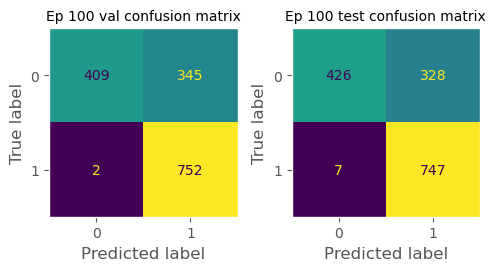


The best epoch: 76 Loss: 0.421203762293 | AUC Val: 0.958 | AUC Test: 0.964
                                         | F1 Val : 0.815 | F1 Test: 0.816


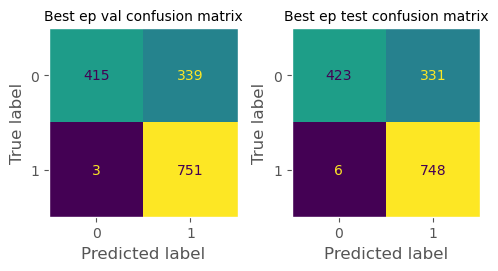

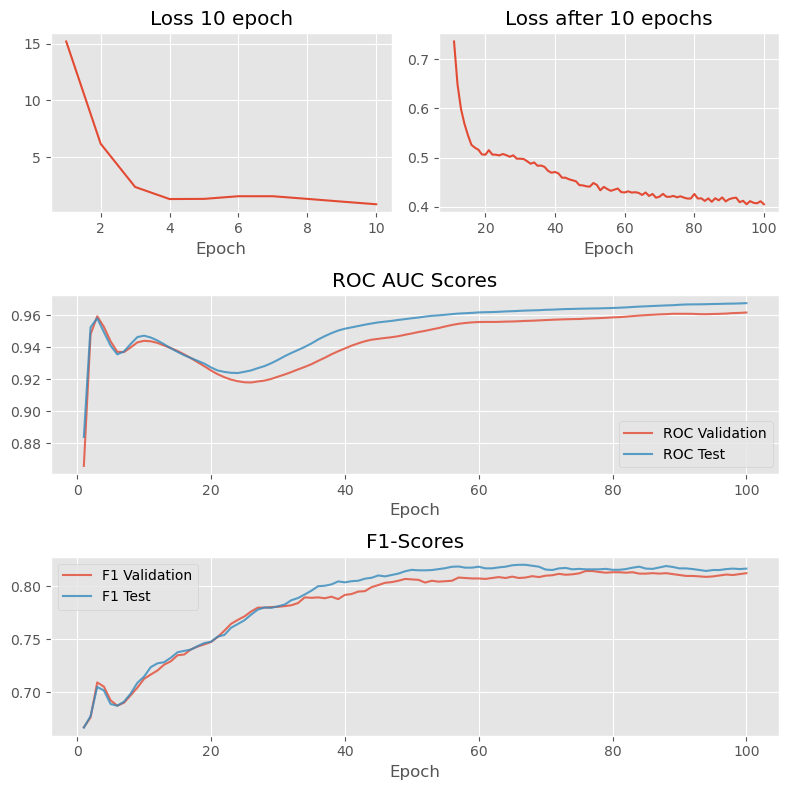

In [43]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv, data.x.shape[1])
print(model)
train(model, data, num_epochs=100)  #  AUC Val: 0.871 | AUC Test: 0.818 | F1 Val : 0.756 | F1 Test: 0.741
                            # new embs AUC Val : 0.962 | AUC Test: 0.967 | F1 Val : 0.813 | F1 Test: 0.817

### 2-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 26.685287475586 | AUC Val: 0.770 | AUC Test: 0.793
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 8.217954635620 | AUC Val: 0.966 | AUC Test: 0.964
                                    | F1 Val : 0.674 | F1 Test: 0.672

[Epoch 3/100] Loss: 3.565386772156 | AUC Val: 0.960 | AUC Test: 0.958
                                    | F1 Val : 0.676 | F1 Test: 0.676

[Epoch 5/100] Loss: 3.358650207520 | AUC Val: 0.964 | AUC Test: 0.964
                                    | F1 Val : 0.678 | F1 Test: 0.683

[Epoch 6/100] Loss: 2.827809810638 | AUC Val: 0.971 | AUC Test: 0.969
                                    | F1 Val : 0.687 | F1 Test: 0.692

[Epoch 7/100] Loss: 2.174519777298 | AUC Val: 0.974 | AUC Test: 0.972
                                    | F1 Val : 0.698 | F1 Test: 0.702

[Epoch 8/100] Loss: 1.606934666

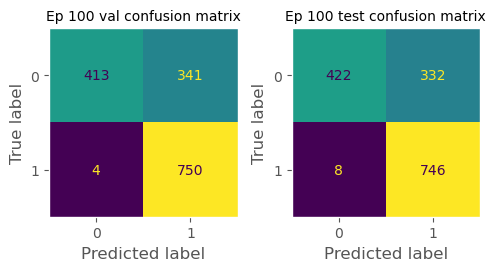


The best epoch: 77 Loss: 0.406963944435 | AUC Val: 0.968 | AUC Test: 0.969
                                         | F1 Val : 0.814 | F1 Test: 0.810


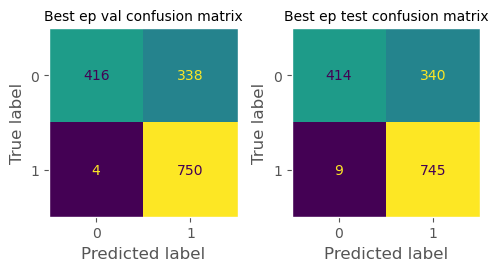

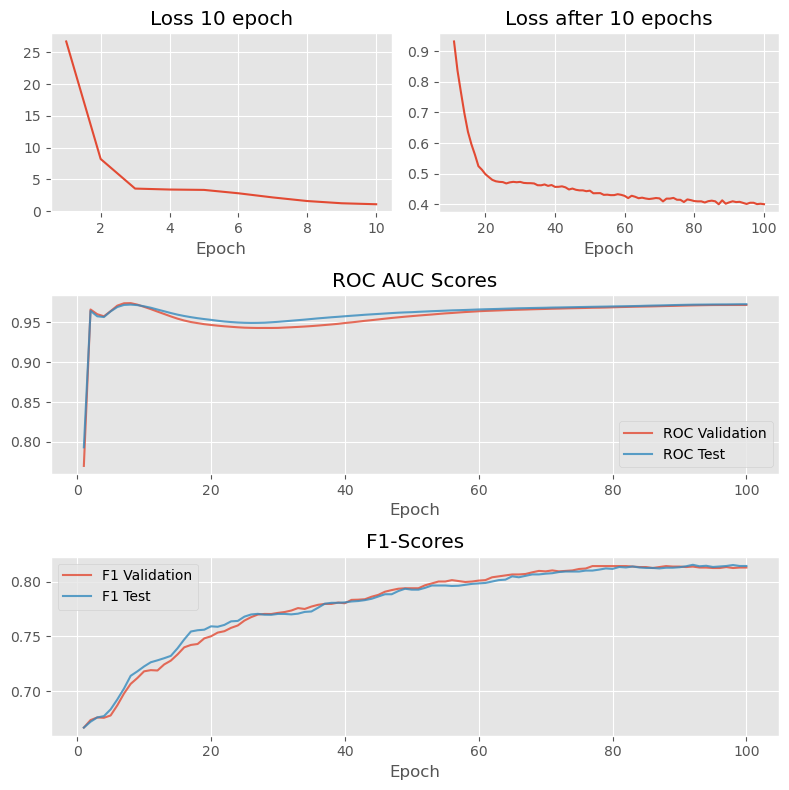

In [44]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, data, num_epochs=100)   # AUC Val : 0.803 | AUC Test: 0.750 | F1 Val : 0.759 | F1 Test: 0.702
                            # new embs AUC Val : 0.972 | AUC Test: 0.973 | F1 Val : 0.813 | F1 Test: 0.814

### 3-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 14.898523330688 | AUC Val: 0.929 | AUC Test: 0.937
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 3.040604829788 | AUC Val: 0.945 | AUC Test: 0.953
                                    | F1 Val : 0.669 | F1 Test: 0.669

[Epoch 4/100] Loss: 1.588510990143 | AUC Val: 0.938 | AUC Test: 0.950
                                    | F1 Val : 0.671 | F1 Test: 0.671

[Epoch 5/100] Loss: 1.280545353889 | AUC Val: 0.943 | AUC Test: 0.953
                                    | F1 Val : 0.675 | F1 Test: 0.674

[Epoch 6/100] Loss: 0.973873496056 | AUC Val: 0.947 | AUC Test: 0.954
                                    | F1 Val : 0.682 | F1 Test: 0.677

[Epoch 7/100] Loss: 0.775879979134 | AUC Val: 0.950 | AUC Test: 0.956
                                    | F1 Val : 0.688 | F1 T

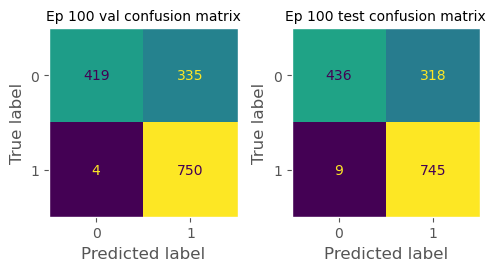


The best epoch: 81 Loss: 0.402506411076 | AUC Val: 0.977 | AUC Test: 0.976
                                         | F1 Val : 0.823 | F1 Test: 0.825


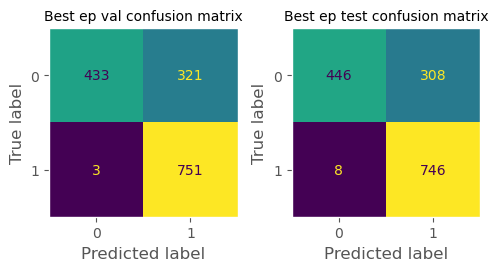

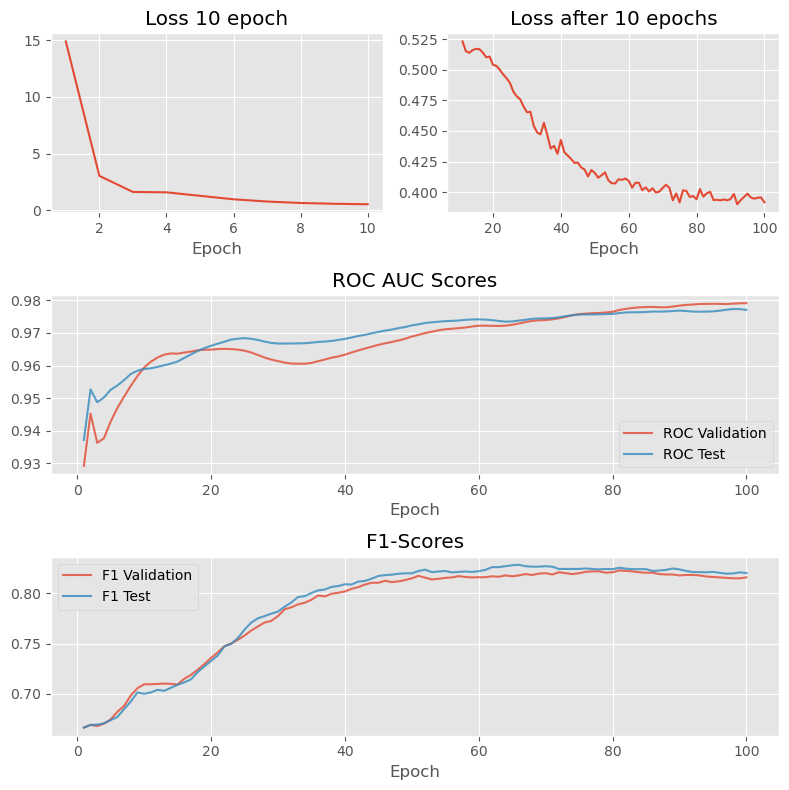

In [45]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            num_layers=3,
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, data, num_epochs=100)  #      AUC Val: 0.929 | AUC Test: 0.875 | F1 Val : 0.712 | F1 Test: 0.692
                                # new embs AUC Val: 0.977 | AUC Test: 0.976 | F1 Val : 0.823 | F1 Test: 0.825

### 4-layer GCN, hidden=256, output=128

LinkPredictionModel(
  (encoder): ModuleList(
    (0): GCNConv(768, 256)
    (1): ReLU()
    (2): GCNConv(256, 256)
    (3): ReLU()
    (4): GCNConv(256, 256)
    (5): ReLU()
    (6): GCNConv(256, 128)
  )
)
[Epoch 1/100] Loss: 5.403267860413 | AUC Val: 0.892 | AUC Test: 0.901
                                    | F1 Val : 0.667 | F1 Test: 0.667

[Epoch 2/100] Loss: 1.010666251183 | AUC Val: 0.895 | AUC Test: 0.899
                                    | F1 Val : 0.669 | F1 Test: 0.668

[Epoch 6/100] Loss: 0.590926527977 | AUC Val: 0.936 | AUC Test: 0.939
                                    | F1 Val : 0.672 | F1 Test: 0.673

[Epoch 7/100] Loss: 0.577483832836 | AUC Val: 0.941 | AUC Test: 0.946
                                    | F1 Val : 0.677 | F1 Test: 0.677

[Epoch 8/100] Loss: 0.571569263935 | AUC Val: 0.945 | AUC Test: 0.950
                                    | F1 Val : 0.682 | F1 Test: 0.681

[Epoch 9/100] Loss: 0.565376639366 | AUC Val: 0.947 | AUC Test: 0.953
                 

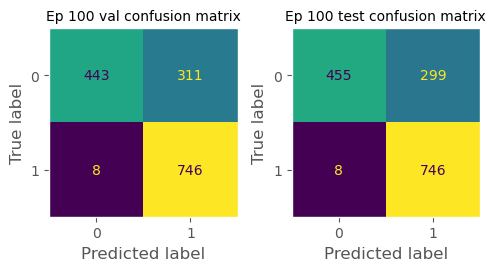


The best epoch: 42 Loss: 0.404166936874 | AUC Val: 0.974 | AUC Test: 0.974
                                         | F1 Val : 0.828 | F1 Test: 0.832


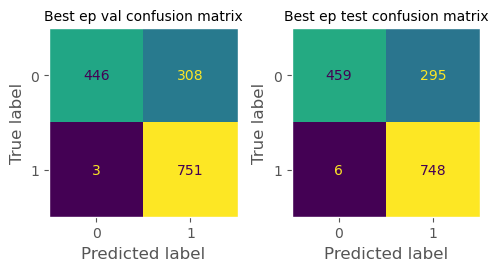

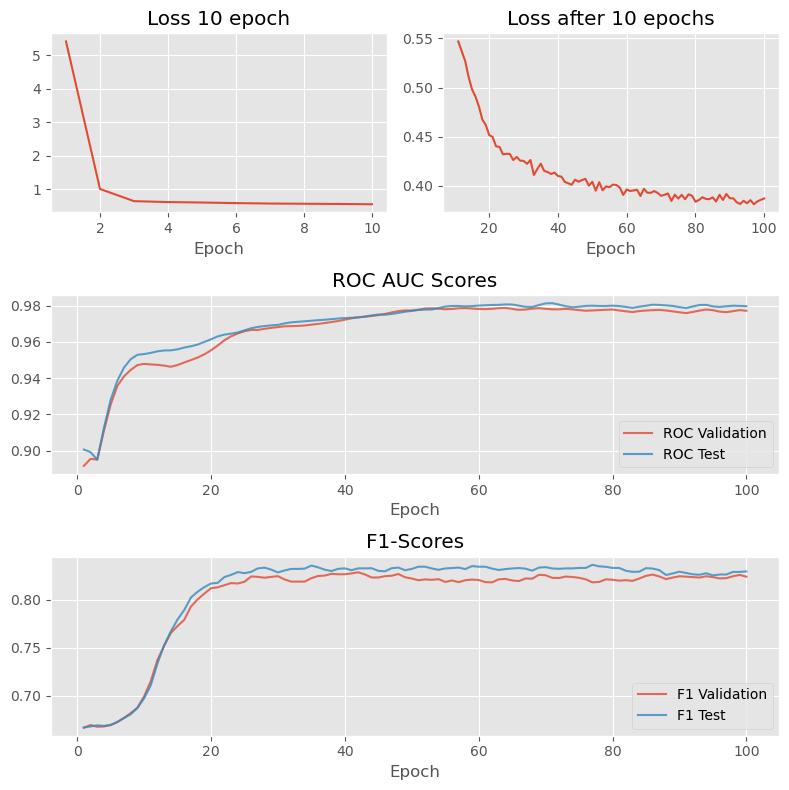

In [46]:
model = LinkPredictionModel(torch_geometric.nn.GCNConv,
                            data.x.shape[1],
                            num_layers=4,
                            sz_hid=256,
                            sz_out=128)
print(model)
train(model, data, num_epochs=100) # | AUC Val: 0.924 | AUC Test: 0.894 | F1 Val : 0.685 | F1 Test: 0.695
                            #new embs  AUC Val: 0.974 | AUC Test: 0.974 | F1 Val : 0.828 | F1 Test: 0.832

# Comparison part

Most code and comments are copied from https://github.com/allenai/scidocs/blob/master/scidocs/recomm_click_eval.py

## Upload propensity scores

In [49]:
recomm_path = data_path + 'recomm/'
propensity_score_path = recomm_path + 'propensity_scores.json'

with open(propensity_score_path) as f_in:
    adjClickDistribution = torch.Tensor(json.load(f_in)['scores'])

adjClickDistribution

tensor([0.5929, 0.3906, 0.3019, 0.2665, 0.2509, 0.2073, 0.1840, 0.2287, 0.2125,
        0.2423])

In [52]:
#adjust to sum to one:
adjClickDistribution = adjClickDistribution * len(adjClickDistribution) / (
    sum(adjClickDistribution))
adjClickDistribution

tensor([2.0604, 1.3574, 1.0491, 0.9261, 0.8719, 0.7204, 0.6394, 0.7948, 0.7385,
        0.8420])

I don't really know where those scores are coming from and in the last transformation, it doesn't really sum to 1... (the code was copied from github)

I was looking for propensity scores in the whole `scidocs` library, but there's only one file

Also, the basic path is `data/`, here's the example from code in https://github.com/allenai/scidocs/blob/master/scripts/run.py#L24

```parser.add_argument('--data-path', default=None, help='path to the data directory where scidocs files reside. If None, it will default to the `data/` directory')```

For all recommendation system files they refer to `/recomm` (stated in the same file)

```parser.add_argument('--recomm', '--recomm_embeddings_path', dest='recomm', help='path to recommender related embeddings')```

So the whole path looks like `/data/recomm` which is exactly where the used file lies

## Upload test or validation data (their metrics were achieved on **test** dataset)

In [91]:
test_data_path = recomm_path + 'test.csv'
val_data_path = recomm_path + 'val.csv'

df_test = pd.read_csv(test_data_path)

df_test.head()

,pid,clicked_pid,similar_papers_avail_at_time
0,70fc27072f024415a812c2d819bfc6b50eefe326,65d3b7df2087134220369ac5c9f4f440ca538d08,"5b2646605d804285176574c5f27f2974e83288e2,fee0c..."
1,f781499f9a2a81dfe50068d32bfe9f36449f1dc6,06c0db75dce988e17e27fb4f2269815c6075e8d8,"562e2a1300e96cf882e17d7dee711d2dedac0580,06c0d..."
2,f8e8f26442a022b2a89b498d7e80701a86ff6691,2268a522cc5a749da38b4e9aaaa6f4239e82ca31,"2268a522cc5a749da38b4e9aaaa6f4239e82ca31,0033a..."
3,92113b42ff8b9a09e45e7292b201e225bc89c379,171444e1456e3136ff4bec661eea5e75464d39b8,"f3fdfc21ff5fb93625a65063f6f32b11d42a3218,17144..."
4,b7fcbb19c75ad65be522b64d5f4b23dbcb3b883b,90096a59f94b552351ad386db7bee8f1932badc8,"08663b3b57c85d8270acf1931041050d26599c7e,90096..."


`similar_papers_avail_at_time` always have 10 papers inside divided by commas as one string

In [85]:
display(df_test['similar_papers_avail_at_time'])

df_test['similar_papers_avail_at_time'].str.split(',').apply(len).describe()

0      5b2646605d804285176574c5f27f2974e83288e2,fee0c...
1      562e2a1300e96cf882e17d7dee711d2dedac0580,06c0d...
2      2268a522cc5a749da38b4e9aaaa6f4239e82ca31,0033a...
3      f3fdfc21ff5fb93625a65063f6f32b11d42a3218,17144...
4      08663b3b57c85d8270acf1931041050d26599c7e,90096...
                             ...                        
995    2dbe0138ca07dbd9daa3d8d118c1ee2c49620b90,1c2a6...
996    577c4b3ad6ff6324878623c35f47ea4457d415d9,f3372...
997    7e5e5063cba7f4e41c2366eab80c1b2c6aaefa77,a6949...
998    0f31a74ec5cecab2314358bec4457738354bbc76,66f2c...
999    34b4a6ba45efe90c77b245890227cb35c598849e,784e3...
Name: similar_papers_avail_at_time, Length: 1000, dtype: object

count    1000.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
Name: similar_papers_avail_at_time, dtype: float64

### Check the data consistency with our embeddings dataset

Unique values in `val`/`test` dataset

In [86]:
np.unique(
    np.concatenate([
        df_test['pid'].unique(),
        df_test['clicked_pid'].unique(),
        np.concatenate(df_test['similar_papers_avail_at_time'].str.split(','))])
    ).shape


(8758,)

In [87]:
len(set(Grec.nodes))

4716

Intersection of `ids` in both datasets

In [88]:
len(set(np.concatenate([
        df_test['pid'].unique(),
        df_test['clicked_pid'].unique(),
        np.concatenate(df_test['similar_papers_avail_at_time'].str.split(','))
    ])).intersection(set(Grec.nodes)))

1104

Before it was 90, so the situation improved a little

### Filter the dataset to have only available papers 

In [92]:
# Create mask to filter only available papers in 'pid' and 'clicked_pid' cols
mask = (df_test['pid'].isin(Grec.nodes)) & (df_test['clicked_pid'].isin(Grec.nodes))
df_test = df_test[mask]

# Split the 'sim_papers' col and leave values that are available in the Graph
df_test['similar_papers_avail_at_time'] = df_test['similar_papers_avail_at_time'].str.split(',')
df_test['similar_papers_avail_at_time'] = df_test['similar_papers_avail_at_time'].apply(
                                        lambda ls: [paper for paper in ls if paper in Grec.nodes]
                                        )

# Get rid of rows with less then 2 values (comparison won't make sence)
df_test = df_test[df_test['similar_papers_avail_at_time'].apply(len) > 1]
display(df_test)

# Upload filtered dataset
test_filtered_data_path = recomm_path + 'test_filtered.csv'
df_test.to_csv(test_filtered_data_path, index=False)

,pid,clicked_pid,similar_papers_avail_at_time
4,b7fcbb19c75ad65be522b64d5f4b23dbcb3b883b,90096a59f94b552351ad386db7bee8f1932badc8,"[90096a59f94b552351ad386db7bee8f1932badc8, 821..."
6,b7fcbb19c75ad65be522b64d5f4b23dbcb3b883b,821fd5bed14d6d06c25fbf44123fd7be382f7b4e,"[90096a59f94b552351ad386db7bee8f1932badc8, 821..."
14,6dae703128d9caff2623eb8dfe2526dc6ad7aff5,4a63437aaee3267a5b427588adecb1c73a95b423,"[4a63437aaee3267a5b427588adecb1c73a95b423, 0ce..."
17,cb40a5e6d4fc0290452345791bb91040aed76961,c6a9ca56c93323c0199dd22631d1cf731bdd7ec1,"[8fd1d13e18c5ef8b57296adab6543cb810c36d81, 577..."
18,3d9d1c26a8dc82ca54154d6f2304507ce65bcb35,fc7d91dbb549a5c834d663944670bf4f08bc9b00,"[7874c01633ca800b6e38b188dd0b1cbf6f3f9ece, 0dc..."
...,...,...,...
935,1e56ed3d2c855f848ffd91baa90f661772a279e1,3d74d241af53d85cbc74f73a785fddd675f0e644,"[3d74d241af53d85cbc74f73a785fddd675f0e644, 9e6..."
937,cf755dd097b7286e8e53ba637c495229f2587e84,1b49a3b9a44c5213a03129faba81cccc75a4d5ff,"[1b49a3b9a44c5213a03129faba81cccc75a4d5ff, b94..."
948,9a6a8cbb10b719cdb565ca9be01c7bf4df049bf0,560d3334047c0455951a4a672941103bf49c1f40,"[3e5655307333589f52f2aab8678f3e1c9184a88f, b77..."
985,a217e85ca33c46ebb06812fdd30f133a83cd0890,3b3291e1f908f583a478e15fb40bffb6dd26cf14,"[3b3291e1f908f583a478e15fb40bffb6dd26cf14, ad6..."


### Open the `csv` as it was in original code

In [93]:
with open(test_filtered_data_path, 'r') as f_in:
    clicks = f_in.read().splitlines()

print(f"Clicks variable contain {len(clicks[1:])} examples with columns:")

for i, cl in enumerate(clicks[0].split(',')):
    print(f'{i+1}.{cl}')

clicks = clicks[1:]

Clicks variable contain 71 examples with columns:
1.pid
2.clicked_pid
3.similar_papers_avail_at_time


## Comparison for-loop (work in progress)

In [ ]:
correct_order = 0
incorrect_order = 0
adj_correct_order = 0
adj_incorrect_order = 0
ndcg_numerator = 0
adj_ndcg_numerator = 0
adj_demonimator = 0
mrr = 0
adj_mrr = 0
rprec = 0
adj_rprec = 0

output = []


In [105]:
#sp2_embs = pd.read_json('papers_embeddings_sp2.json')
sp2_embs = {}
with open('papers_embeddings_sp2.json', 'r') as f:
    all_sp2_embs = json.load(f)
    for id, emb in tqdm(all_sp2_embs.items(), desc='reading embeddings from file...'):
        if id in Grec.nodes:
            sp2_embs[id] = np.array(emb, dtype=np.float32)
    del all_sp2_embs


reading embeddings from file...: 100%|██████████| 4716/4716 [00:00<00:00, 235744.02it/s]


Function for finding euclidean distance on SPECTER 2 embeddings

In [ ]:
def find_L2_distance_SPECTER2(query_paper_id, comp_paper_id):
    query_emb = sp2_embs[query_paper_id]
    comp_emb = sp2_embs[comp_paper_id]
    dist = euclidean(query_emb, comp_emb)
    return dist  # with -dist we can turn into maximization metric (bigger value -> better result)

Function for receiving dot-product between two paper nodes in GNN (in progress)

In [ ]:
def get_dot_prod_GNN(query_paper, comp_paper):
    dot_prod_res = 0
    return dot_prod_res

In [ ]:
for line in tqdm.tqdm(clicks):
        # Prepare ids from file
        [query_id, clicked_id, other_id_str] = list(csv.reader([line], delimiter=',', quotechar='"'))[0]
        other_ids = other_id_str.strip().split(",")
        position = 1
        paper_score_specter = [] #used for output
        paper_score_gnn = [] #used for output

        # Find positive query-recom scores
        clicked_position = other_ids.index(clicked_id) + 1
        pos_score_specter = find_L2_distance_SPECTER2(query_id, clicked_id)
        pos_score_gnn = get_dot_prod_GNN(query_id, clicked_id)
        paper_score_specter.append([clicked_id, pos_score_specter])
        paper_score_gnn.append([clicked_id, pos_score_gnn])

        # Find negative query-recom scores
        neg_scores_specter = []
        neg_scores_gnn = []
        adj = 1 / adjClickDistribution[clicked_position-1]
        for other_id in other_ids:
            if not other_id == clicked_id:
                neg_score_specter = find_L2_distance_SPECTER2(query_id, other_id)
                neg_score_gnn = get_dot_prod_GNN(query_id, other_id)
                neg_scores_specter.append(neg_score_specter)
                neg_scores_gnn.append(neg_score_gnn)
                paper_score_specter.append([other_id, neg_score_specter])
                paper_score_gnn.append([other_id, neg_score_gnn])
            position = position + 1

        # Find order
        ranked_above = sum(1 for x in neg_scores_specter if x > pos_score_specter)
        ranked_below = sum(1 for x in neg_scores_specter if x < pos_score_specter)
        ## probably rare case of ties:
        ranked_above += sum(0.5 for x in neg_scores_specter if x==pos_score_specter)
        ranked_below += sum(0.5 for x in neg_scores_specter if x==pos_score_specter)
        correct_order = correct_order + ranked_below
        incorrect_order = incorrect_order + ranked_above
        
        # Calculate metrics
        ndcg = 1/np.log2(2 + ranked_above)
        mrr = mrr + 1/(1 + ranked_above)
        ndcg_numerator = ndcg_numerator + ndcg
        rprec = rprec + (1 if ranked_above==0 else 0)
        ## adjusted versions of each metric weight examples by 1 / (propensity score),
        ## need to keep track of both numerator and denominator in weighted terms:
        adj_demonimator = adj_demonimator + adj
        adj_ndcg_numerator = adj_ndcg_numerator + adj*ndcg
        adj_correct_order = adj_correct_order + adj*ranked_below
        adj_incorrect_order = adj_incorrect_order + adj*ranked_above
        adj_mrr = adj_mrr + adj*(1/(1 + ranked_above))
        adj_rprec = adj_rprec + adj*(1 if ranked_above==0 else 0)

        paper_score.sort(key=(lambda x: x[1]), reverse=True)
        paper_ranking = [x for [x, _] in paper_score]
        dict = {}
        dict[query_id] = paper_ranking
        output.append(dict)

In [ ]:
metrics = {
    "accuracy": correct_order / (correct_order + incorrect_order),
    "ndcg": ndcg_numerator / len(clicks),
    "mrr": mrr / len(clicks),
    "Rprec/P@1": rprec / len(clicks),
    "Adj-accuracy": adj_correct_order / (adj_incorrect_order + adj_correct_order),
    "Adj-ndcg": adj_ndcg_numerator / adj_demonimator,
    "Adj-mrr": adj_mrr / adj_demonimator,
    "Adj-Rprec/P@1": adj_rprec / adj_demonimator
}

metrics